In [1]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from pandas import read_csv

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

## Load Data

In [4]:
config = {}

# config['dates'] = ["20240701", "20240705", "20240708", "20240710", "20240712"]
config['dates'] = ["20240701", "20240705", "20240710", "20240712", "20240715", "20240717"]

config['path_to_data'] = data_path+"ROMY_geoelectric/data/"

config['path_to_figs'] = data_path+"ROMY_geoelectric/figures/"


In [5]:
header = ["channel", "spacing_m", "layer", "R_ohmm", "I_mA", "U_muV", "XX"]

dfs = []
for date in config['dates']:

    df0 = read_csv(config['path_to_data']+f"ROMY_{date}.csv", names=header)

    dfs.append(df0)


In [6]:
def __get_image(df0, value="SD"):
    max_layer = int(df0.layer.max())
    min_channel = int(df0.channel.min())
    max_channel = int(df0.channel.max())

    # image dummy
    img = np.ones((max_layer, max_channel))*np.nan

    # offset of layers to form triangle
    off = 0

    # loop over layers and channels
    for l in range(1, max_layer+1):
        for c in range(1, max_channel+1-off):
            _df = df0[(df0.layer == l) & (df0.channel == c)]
            if _df.empty:
                img[l-1, c-1+off] = np.nan
            elif float(_df.XX) == -1:
                img[l-1, c-1+off] = np.nan
            else:
                # img[l-1, c-1] = _df.SD
                img[l-1, c-1+off] = _df[value]
        off += 2

    return img[:, min_channel-1:max_channel]

In [33]:
imgs = []

for _df0 in dfs:
    _df0['new'] = _df0["U_muV"]/_df0["I_mA"]
    imgs.append(__get_image(_df0, value="R_ohmm"))

In [34]:
dfs[0]

,channel,spacing_m,layer,R_ohmm,I_mA,U_muV,XX,new
0,36.0,2.0,1,5.01,0.05,0.0199,-1.0,0.398000
1,37.0,2.0,1,1.13,0.05,-0.0045,-1.0,-0.090000
2,38.0,2.0,1,342.17,0.50,13.6145,0.2,27.229000
3,39.0,2.0,1,372.97,0.50,14.8402,0.0,29.680400
4,40.0,2.0,1,617.71,0.50,24.5779,0.0,49.155800
...,...,...,...,...,...,...,...,...
445,39.0,2.0,14,4.60,50.00,0.1745,3.2,0.003490
446,40.0,2.0,14,6637.61,5.00,-25.1526,1.4,-5.030520
447,41.0,2.0,14,187.50,50.00,-7.1052,0.3,-0.142104
448,36.0,2.0,15,150267.64,0.05,-4.9825,-1.0,-99.650000


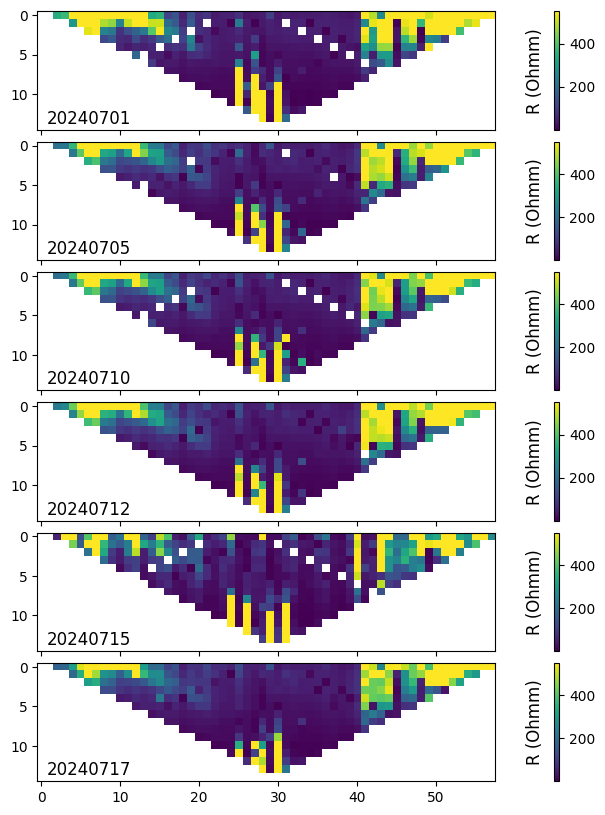

In [35]:
def __makeplot(imgs):

    from matplotlib.colors import LogNorm

    Nrow, Ncol = len(imgs), 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    vmax = 550

    for j, im in enumerate(imgs):
        _im = ax[j].imshow(im, cmap="viridis", vmax=vmax)

        cb = plt.colorbar(_im)
        cb.set_label("R (Ohmm)", fontsize=font, labelpad=-50, color="k")


        ax[j].text(.02, .17, config['dates'][j], ha='left', va='top', transform=ax[j].transAxes, fontsize=font)


    plt.show();
    return fig

fig = __makeplot(imgs);

fig.savefig(config['path_to_figs']+f"RG_absolute.png", format="png", dpi=150, bbox_inches='tight')


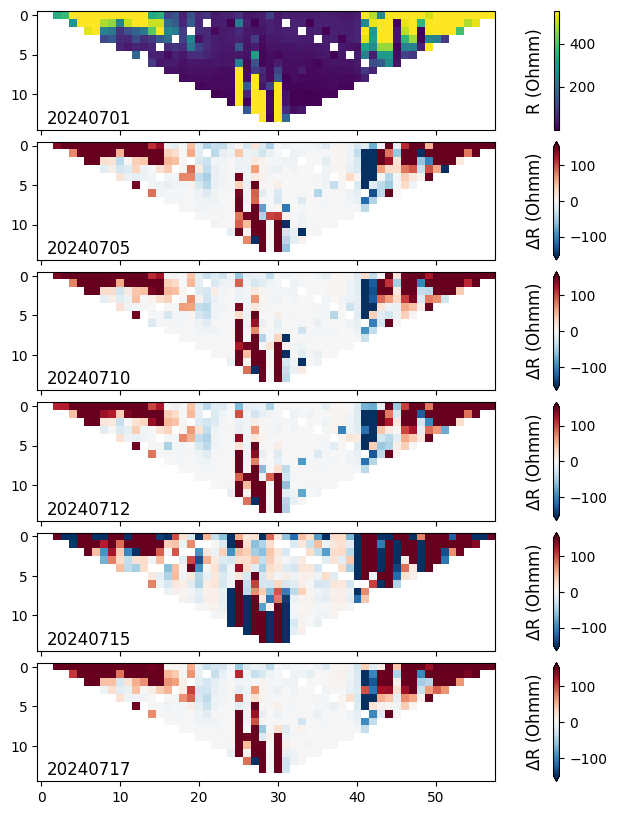

In [36]:
def __makeplot(imgs):

    from matplotlib.colors import LogNorm

    Nrow, Ncol = len(imgs), 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    vmax = 550

    for j, im in enumerate(imgs):
        if j == 0:
            im0 = im
            _im = ax[j].imshow(im, cmap="viridis", vmax=vmax)

            cb = plt.colorbar(_im)
            cb.set_label("R (Ohmm)", fontsize=font, labelpad=-50, color="k")

        else:
            _im = ax[j].imshow(im0-im, cmap="RdBu_r", vmin=-150, vmax=150)
            # _im = ax[j].imshow(im0-im, cmap="RdBu_r", norm=LogNorm(vmin=10, vmax=50))

            cb = plt.colorbar(_im, extend="both")
            cb.set_label("$\Delta$R (Ohmm)", fontsize=font, labelpad=-60, color="k")

        ax[j].text(.02, .17, config['dates'][j], ha='left', va='top', transform=ax[j].transAxes, fontsize=font)


    plt.show();
    return fig

fig = __makeplot(imgs);

fig.savefig(config['path_to_figs']+f"RG_change.png", format="png", dpi=150, bbox_inches='tight')


## Test

In [182]:
date = config['dates'][1]

header = ["channel", "spacing_m", "layer", "R_ohmm", "I_mA", "U_muV", "XX"]

df0 = read_csv(config['path_to_data']+f"ROMY_{date}_new.csv", names=header)

df0

,channel,spacing_m,layer,R_ohmm,I_mA,U_muV,XX
0,36.0,2.0,1,1.37,0.05,-0.0055,-1.0
1,37.0,2.0,1,10.92,0.05,0.0434,-1.0
2,38.0,2.0,1,205.32,0.50,8.1694,0.6
3,39.0,2.0,1,216.08,0.50,8.5976,0.4
4,40.0,2.0,1,363.38,0.50,14.4586,0.2
...,...,...,...,...,...,...,...
445,39.0,2.0,14,4.31,50.00,0.1635,2.1
446,40.0,2.0,14,4936.16,5.00,-18.7051,1.2
447,41.0,2.0,14,246.37,50.00,-9.3360,0.2
448,36.0,2.0,15,148733.56,0.05,-4.9316,-1.0


In [165]:
max_layer = int(df0.layer.max())
min_channel = int(df0.channel.min())
max_channel = int(df0.channel.max())

img = np.ones((max_layer, max_channel))*np.nan

In [167]:
value = "SD"

off = 0
for l in range(1, max_layer+1):
    for c in range(1, max_channel+1-off):
        _df = df0[(df0.layer == l) & (df0.channel == c)]
        if _df.empty:
            img[l-1, c-1+off] = np.nan
        else:
            # img[l-1, c-1] = _df.SD
            img[l-1, c-1+off] = _df[value]
    off += 0

/tmp/ipykernel_682808/2320668851.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  img[l-1, c-1+off] = _df[value]


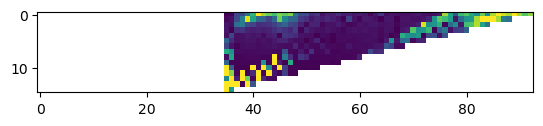

In [168]:
vmax = np.percentile(df0[value], 95)

plt.imshow(img, cmap="viridis", vmax=vmax)